In [1]:
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import xarray as xr
import glob
import om4labs.om4common as om4
import cftime

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

out_path_fig = '/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/'
out_path_data = '/work/Katherine.Turner/smaller_projects/hifreq-variability/data/'

In [4]:
df = pd.read_csv('/work/Katherine.Turner/tempest-extremes/CM4_cmip/node_files/SH_stormtraj.csv', delimiter='\t')
#df = pd.read_csv('/work/Katherine.Turner/tempest-extremes/ESM4/node_files/SH_SN.csv', delimiter='\t')

In [5]:
df

,Event,Year,Month,Day,Time,Lon,Lat,SLP
0,1,151,1,1,6,143.125,-55.5,96680.77
1,1,151,1,1,12,149.375,-54.5,96654.59
2,1,151,1,1,18,154.375,-55.5,96571.02
3,1,151,1,2,0,159.375,-55.5,96802.56
4,1,151,1,2,12,166.875,-55.5,97098.59
...,...,...,...,...,...,...,...,...
4567185,245891,650,12,31,0,313.125,-61.5,97909.31
4567186,245891,650,12,31,6,313.125,-61.5,98161.96
4567187,245891,650,12,31,12,314.375,-61.5,98411.21
4567188,245891,650,12,31,18,315.625,-61.5,98517.61


## Creating Dataset for number of storm centers per month for every month of the years included in the model runs

In [6]:
monthly_dates = xr.cftime_range(start="0151-01-01", end="0650-12-31", freq='MS', calendar='noleap')
monthly_centers = np.ones(len(monthly_dates))*np.nan
monthly_tracks = np.ones(len(monthly_dates))*np.nan

for i, date in enumerate(monthly_dates):
    storms_date = df[ (df['Month']==date.month) & (df['Year']==date.year)]
    monthly_centers[i] = len(storms_date)
    monthly_tracks[i] = len(storms_date['Event'].unique())

In [7]:
ds_out = xr.Dataset(
    data_vars=dict(
        center_counts = (["time"], monthly_centers),
        track_counts = (["time"], monthly_tracks),
    ),
    coords=dict(
        time=monthly_dates,
    ),
    attrs=dict(description="Monthly storm counts for CM4 500-year piControl")
)
ds_out

<xarray.Dataset>
Dimensions:        (time: 6000)
Coordinates:
  * time           (time) object 0151-01-01 00:00:00 ... 0650-12-01 00:00:00
Data variables:
    center_counts  (time) float64 661.0 694.0 790.0 847.0 ... 779.0 708.0 736.0
    track_counts   (time) float64 39.0 44.0 53.0 55.0 ... 50.0 50.0 44.0 46.0
Attributes:
    description:  Monthly storm counts for CM4 500-year piControl

In [8]:
ds_out.to_netcdf('/work/Katherine.Turner/smaller_projects/hifreq-variability/data/CM4_cmip_monthly_storms.nc')

In [9]:
storms_seasonal = ds_out.center_counts.resample(time='QS-DEC').sum()

In [17]:
idx_jja = storms_seasonal.time.dt.month == 6
idx_djf = storms_seasonal.time.dt.month == 12

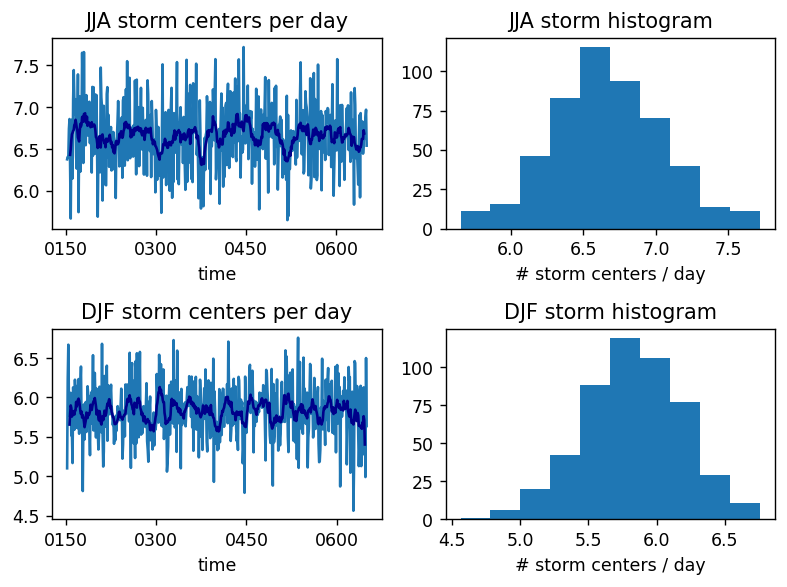

In [30]:
fig, axs = plt.subplots(ncols=2, nrows=2, dpi=125)
axs=axs.flatten()

(1/(92*4) * storms_seasonal)[idx_jja].plot(ax=axs[0])
(1/(92*4) * storms_seasonal)[idx_jja].rolling(time=10,center=True).mean().plot(ax=axs[0], color='darkblue')
axs[0].set_title('JJA storm centers per day')

(1/(92*4) * storms_seasonal)[idx_jja].plot.hist(ax=axs[1])
axs[1].set_title('JJA storm histogram')
axs[1].set_xlabel('# storm centers / day')

(1/(90*4) * storms_seasonal)[idx_djf][1:-1].plot(ax=axs[2])
(1/(90*4) * storms_seasonal)[idx_djf].rolling(time=10,center=True).mean().plot(ax=axs[2], color='darkblue')
axs[2].set_title('DJF storm centers per day')

(1/(90*4) * storms_seasonal)[idx_djf][1:-1].plot.hist(ax=axs[3])
axs[3].set_title('DJF storm histogram')
axs[3].set_xlabel('# storm centers / day')

for i in range(4):
    axs[i].set_ylabel('')
    
plt.tight_layout()
plt.savefig(f"{out_path_fig}CM4_cmip_storm_distributions.png", format='png', dpi=100)

## Finding high-storm and low-storm years

In [31]:
storms_djf = storms_seasonal[idx_djf][1:-1]
storms_jja = storms_seasonal[idx_jja]

In [39]:
lo_djf = storms_djf.sortby(storms_djf).time[:50]
hi_djf = storms_djf.sortby(storms_djf).time[-50:]

idx_hi_djf = storms_djf.time.isin(hi_djf)
idx_lo_djf = storms_djf.time.isin(lo_djf)

storms_djf[idx_hi_djf].mean(), storms_djf[idx_lo_djf].mean()

In [40]:
lo_jja = storms_jja.sortby(storms_jja).time[:50]
hi_jja = storms_jja.sortby(storms_jja).time[-50:]

idx_hi_jja = storms_jja.time.isin(hi_jja)
idx_lo_jja = storms_jja.time.isin(lo_jja)

storms_jja[idx_hi_jja].mean(), storms_jja[idx_lo_jja].mean()

(<xarray.DataArray 'center_counts' ()>
 array(2704.38),
 <xarray.DataArray 'center_counts' ()>
 array(2205.96))

In [ ]:
event_counts = np.zeros(len(year_counts_winter))
mean_slp = np.zeros(len(year_counts_winter))
mean_windmax = np.zeros(len(year_counts_winter))
for i, year in enumerate(year_counts_winter.index):
    event_counts[i] = len(df_winter[df_winter['Year'] == year]['Event'].value_counts())
    mean_slp[i] = df_winter[df_winter['Year'] == year]['SLP'].mean()
    mean_windmax[i] = df_winter[df_winter['Year'] == year]['Windspeed'].mean()

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
axs[0].scatter(year_counts_winter, 1e-2*mean_slp)
axs[1].scatter(year_counts_winter, mean_windmax)

axs[0].set_ylabel('SLP low (hPa)')
axs[0].set_xlabel('Storm centers per winter')

axs[1].set_ylabel('Max windspeed (m s$^{-1}$)')
axs[1].set_xlabel('Storm centers per winter')
#np.corrcoef(year_counts, mean_windmax)
plt.tight_layout()

## Creating maps of storm locations for climatology, strongest 10%, and weakest 10%

In [42]:
import glob
files = glob.glob('/work/Katherine.Turner/tempest-extremes/CM4_cmip/comp_slp/masked*.nc')

In [47]:
for file in files:
    ds_mask = xr.open_dataset(file, use_cftime=True)
    da = ds_mask.mask.resample(time='M').sum()
    da.to_dataset(name='mask').to_netcdf(f'/work/Katherine.Turner/tempest-extremes/CM4_cmip/mask/mask_{file[-12:]}')
    del da, ds_mask

In [48]:
ds_mask = xr.open_mfdataset('/work/Katherine.Turner/tempest-extremes/CM4_cmip/mask/mask_*.nc', use_cftime=True)

In [62]:
ds_mask.time

<xarray.DataArray 'time' (time: 6100)>
array([cftime.DatetimeNoLeap(151, 1, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(151, 2, 28, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(151, 3, 31, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(650, 11, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(650, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(651, 1, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0151-01-31 00:00:00 ... 0651-01-31 00:00:00

In [66]:
midx_djf = ds_mask.time.dt.month.isin([1,2,12])
midx_jja = ds_mask.time.dt.month.isin([6,7,8])

midx_hi_djf = (ds_mask.time.dt.year.isin(hi_djf.dt.year) & ds_mask.time.dt.month.isin([12])) | (ds_mask.time.dt.year.isin(hi_djf.dt.year+1) & ds_mask.time.dt.month.isin([1,2])) 
midx_lo_djf = (ds_mask.time.dt.year.isin(lo_djf.dt.year) & ds_mask.time.dt.month.isin([12])) | (ds_mask.time.dt.year.isin(lo_djf.dt.year+1) & ds_mask.time.dt.month.isin([1,2]))

midx_hi_jja = (ds_mask.time.dt.year.isin(hi_jja.dt.year) & ds_mask.time.dt.month.isin([6,7,8])) 
midx_lo_jja = (ds_mask.time.dt.year.isin(lo_jja.dt.year) & ds_mask.time.dt.month.isin([6,7,8])) 

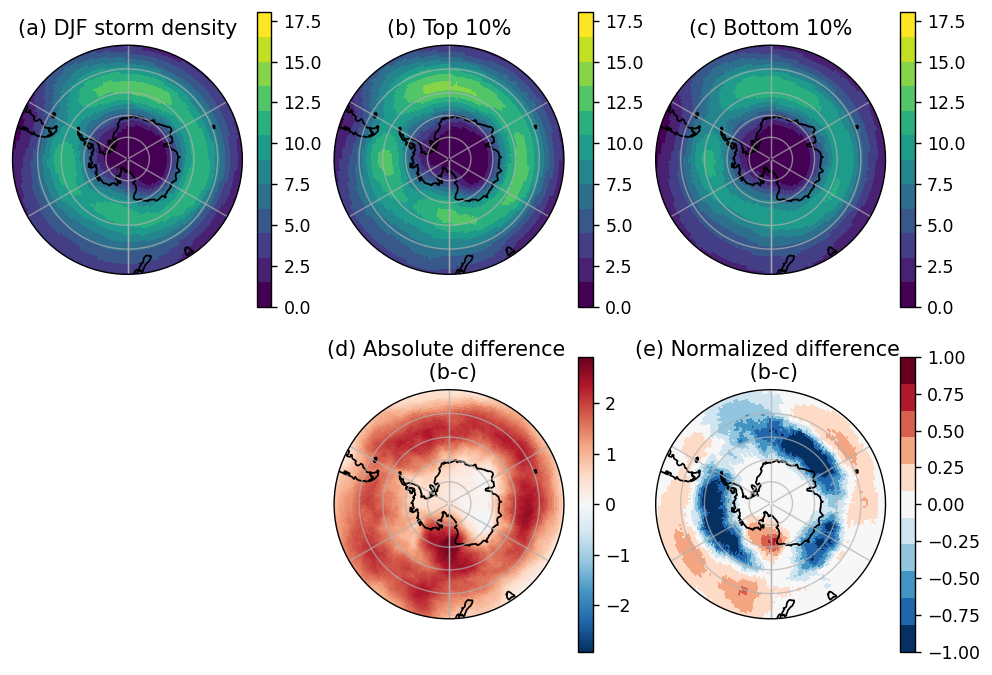

In [87]:
## Summer month storm activity

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,5.5), dpi=125,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()


(1/(3*500*4) * ds_mask.mask[midx_djf,:,:].sum(dim='time')).plot(ax=axs[0],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12),
                                                               cbar_kwargs={'label':''},
                                                               )

axs[0].set_title('(a) DJF storm density')

(1/(3*50*4) * ds_mask.mask[midx_hi_djf,:,:].sum(dim='time')).plot(ax=axs[1],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12),
                                                                 cbar_kwargs={'label':''},
                                                                 )
axs[1].set_title('(b) Top 10%')

(1/(3*50*4) * ds_mask.mask[midx_lo_djf,:,:].sum(dim='time')).plot(ax=axs[2],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12),
                                                               cbar_kwargs={'label':''},
                                                                 )

axs[2].set_title('(c) Bottom 10%')
                                                            

# differences between high and low years

(1/(3*50*4) * (ds_mask.mask[midx_hi_djf,:,:].sum(dim='time') - ds_mask.mask[midx_lo_djf,:,:].sum(dim='time'))).plot(ax=axs[4],
                                                                                                    x='lon', y='lat',
                                                                                                    transform=ccrs.PlateCarree(),
                                                                                                    #vmax=18, extend='neither',
                                                                                                    #cmap=plt.get_cmap('viridis', 12)
                                                                                                    cbar_kwargs={'label':''},                
                                                                                                   )
axs[4].set_title('(d) Absolute difference \n (b-c)')

((1/2318 * ds_mask.mask[midx_hi_djf,:,:].sum(dim='time') - 
  1/1861 * ds_mask.mask[midx_lo_djf,:,:].sum(dim='time')) /
  1/1861 * ds_mask.mask[midx_lo_djf,:,:].sum(dim='time')).plot(ax=axs[5],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(),
                                                               vmin=-1 , vmax=1, extend='neither',
                                                               cmap=plt.get_cmap('RdBu_r', 11),
                                                               cbar_kwargs={'label':''},
                                                              )

axs[5].set_title('(e) Normalized difference \n (b-c)')


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
axs[3].remove()
plt.tight_layout()

plt.savefig(f"{out_path_fig}storm_activity_djf_CM4-500.png", format='png', dpi=100)

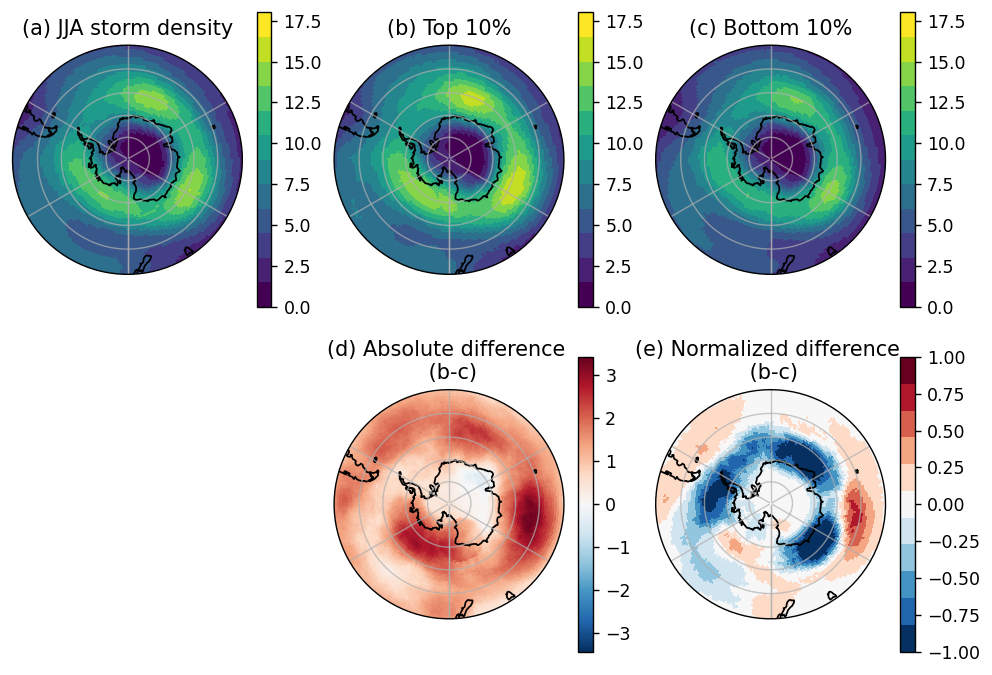

In [89]:
## Winter month storm activity

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,5.5), dpi=125,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()


(1/(3*500*4) * ds_mask.mask[midx_jja,:,:].sum(dim='time')).plot(ax=axs[0],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12),
                                                               cbar_kwargs={'label':''},
                                                               )

axs[0].set_title('(a) JJA storm density')

(1/(3*50*4) * ds_mask.mask[midx_hi_jja,:,:].sum(dim='time')).plot(ax=axs[1],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12),
                                                                 cbar_kwargs={'label':''},
                                                                 )
axs[1].set_title('(b) Top 10%')

(1/(3*50*4) * ds_mask.mask[midx_lo_jja,:,:].sum(dim='time')).plot(ax=axs[2],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12),
                                                               cbar_kwargs={'label':''},
                                                                 )

axs[2].set_title('(c) Bottom 10%')
                                                            

# differences between high and low years

(1/(3*50*4) * (ds_mask.mask[midx_hi_jja,:,:].sum(dim='time') - ds_mask.mask[midx_lo_jja,:,:].sum(dim='time'))).plot(ax=axs[4],
                                                                                                    x='lon', y='lat',
                                                                                                    transform=ccrs.PlateCarree(),
                                                                                                    #vmax=18, extend='neither',
                                                                                                    #cmap=plt.get_cmap('viridis', 12)
                                                                                                    cbar_kwargs={'label':''},                
                                                                                                   )
axs[4].set_title('(d) Absolute difference \n (b-c)')

((1/2704 * ds_mask.mask[midx_hi_jja,:,:].sum(dim='time') - 
  1/2205 * ds_mask.mask[midx_lo_jja,:,:].sum(dim='time')) /
  1/2205 * ds_mask.mask[midx_lo_jja,:,:].sum(dim='time')).plot(ax=axs[5],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(),
                                                               vmin=-1 , vmax=1, extend='neither',
                                                               cmap=plt.get_cmap('RdBu_r', 11),
                                                               cbar_kwargs={'label':''},
                                                              )

axs[5].set_title('(e) Normalized difference \n (b-c)')


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
axs[3].remove()
plt.tight_layout()

plt.savefig(f"{out_path_fig}storm_activity_jja_CM4-500.png", format='png', dpi=100)